### Compare posterior distributions predicted from ABC for 2004 outbreak
Compare $\beta$, $\epsilon$, $\mu_1$, $\mu_2$ and $\sigma$ distributions


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import math
from scipy.interpolate import interp1d
import seaborn as sns
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.mlab import griddata
from datetime import datetime
from scipy import stats
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

In [2]:
def gillespieSEIR_season( beta, mu1,mu2, sigma,epsilon,initial=[1500, 0, 0, 0]):
    event_time = []
    pop = []
    N = sum(initial)
    pop.append(initial) # SEIR
    event_time.append(0)
    times = 0
    ind = 0
    year = 1
    cuminf = []
    cuminf.append(0)
    events = []
    num_external= 0
    num_internal = 0
    Rtotal = 1
    death = 0
    while Rtotal>0:
        state = np.zeros(shape= (4,12))
        
        ############################### Seasonality #######################################
        if np.round(times)%365 <= 120:
            E = epsilon
        else:
            E = 0
        ####################################################################################
        #################################### EVENTS ########################################
        ####################################################################################    
        
        R_external = E*pop[ind][0]
        state[:,0] = [-1,1,0,0]
        
        R_se = beta*(pop[ind][0])*(pop[ind][2])/N  
        state[:,1] = [-1, 1, 0, 0]
        
        R_ei = sigma*pop[ind][1]
        state[:,2] = [0, -1, 1, 0]
        
        R_ir = mu2*pop[ind][2]
        state[:,3] = [0,0,-1,1]   

        R_is = mu1*pop[ind][2]
        state[:,4] = [1,0,-1,0]
        
########################## RATES ##############################
        rate = [R_external, R_se, R_ei,  R_ir,  R_is]

        Rtotal = sum(rate)

        delta_t= -np.log(np.random.uniform(0,1))/Rtotal
        P = np.random.uniform(0,1)*Rtotal
        
        if Rtotal>0:
            times =times+ delta_t
            event = np.min(np.where(P<=np.cumsum(rate)))
            events.append(event)
            event_time.append(times)
            pop.append(pop[ind]+state[:,event])
            if event == 0: # Susceptible to Exposed (via external forcing)
                num_external +=1
            if event == 1: # Susceptible to Infected (human to human transmission)
                num_internal +=1
            if event == 2: # Exposed to Infected
                cuminf.append(1 +cuminf[ind] )
            else:
                cuminf.append(0 +cuminf[ind])
            ind=ind+1
        N = sum(pop[ind][:2])
    return event_time, np.array(pop), events, cuminf, num_external, num_internal, death 

In [41]:
def gillespieSEIR_season_exposed(E, beta, mu1,mu2, sigma,epsilon):
    initial = [1500-E, E, 1,0]
    event_time = []
    pop = []
    N = sum(initial)
    pop.append(initial)
    event_time.append(0)
    times = 0
    ind = 0
    year = 1
    cuminf = []
    cuminf.append(1)
    events = []
    num_external= E+1
    num_internal = 0
    Rtotal = 1
    death = 0
    while Rtotal>0:
        state = np.zeros(shape= (4,12))
        
        ############################### Seasonality #######################################
        if np.round(times)%365 <= 120:
            eps = epsilon
        else:
            eps = 0
#         print(eps)
        ####################################################################################
        #################################### EVENTS ########################################
        ####################################################################################    
        
        R_external = eps*pop[ind][0]
        state[:,0] = [-1,1,0,0]
        
        R_se = beta*(pop[ind][0])*(pop[ind][2])/N  
        state[:,1] = [-1, 1, 0, 0]
        
        R_ei = sigma*pop[ind][1]
        state[:,2] = [0, -1, 1, 0]
        

        
        R_ir = mu2*pop[ind][2]
        state[:,3] = [0,0,-1,1]
        

        R_is = mu1*pop[ind][2]
        state[:,4] = [1,0,-1,0]
        

########################## RATES ##############################
        rate = [R_external, R_se, R_ei,  R_ir,  R_is]

        Rtotal = sum(rate)

        delta_t= -np.log(np.random.uniform(0,1))/Rtotal
        P = np.random.uniform(0,1)*Rtotal
        
        if Rtotal>0:
            times =times+ delta_t
            event = np.min(np.where(P<=np.cumsum(rate)))
            events.append(event)
            event_time.append(times)
            pop.append(pop[ind]+state[:,event])
            if event == 0:
                num_external +=1
            if event == 1:
                num_internal +=1
            if event == 3:
                death +=1 
            if event == 2:
                cuminf.append(1 +cuminf[ind] )
            else:
                cuminf.append(0 +cuminf[ind])
            ind=ind+1
        N = sum(pop[ind][:2])
    return event_time, np.array(pop), events, cuminf, num_external, num_internal, death, E

In [42]:
def modesimulations(f, theta, maxtol, dim, external, repeats, mtime, 
                    time_start, cuminf_start, time_outbreak, cuminf_outbreak):
    timing = []
    cumulative = []
    externalinf = []
    internalinf = []
    totalinf = []
    death = []
    
    for k in range(repeats):
        #### GET PARAMETERS ####
        a_β, loc_β, scale_β = stats.gamma.fit(theta[maxtol][:,0])
        a_ϵ, loc_ϵ, scale_ϵ = stats.gamma.fit(theta[maxtol][:,1])
        a_σ, loc_σ, scale_σ = stats.gamma.fit([1/a for a in theta[maxtol][:,2]])
        a_μ1, loc_μ1, scale_μ1 = stats.gamma.fit([1/a for a in theta[maxtol][:,3]])
        a_μ2, loc_μ2, scale_μ2 = stats.gamma.fit([1/a for a in theta[maxtol][:,4]])

        beta = stats.gamma.rvs( a_β, loc_β, scale_β)
        mu1 = 1/stats.gamma.rvs( a_μ1, loc_μ1, scale_μ1)
        mu2 = 1/stats.gamma.rvs( a_μ2, loc_μ2, scale_μ2)
        sigma = 1/stats.gamma.rvs( a_σ, loc_σ, scale_σ)
        if external == 1:
            epsilon = stats.gamma.rvs( a_ϵ, loc_ϵ, scale_ϵ)
        else:
            epsilon = 0

        if len(theta[0][0])==6:
            random_E = np.random.randint(0,dim-1)
            exposed = theta[maxtol][:,5][random_E]
            M = f(exposed, beta, mu1, mu2, sigma, epsilon)
        else:
            M = f(beta, mu1, mu2, sigma, epsilon)

        ###### Run Simulation #####
        externalinf.append(M[4])
        internalinf.append(M[5])
        totalinf.append(M[3][-1])
        death.append(M[6])
        timed = []
        cuminf = []
        for ind, x in enumerate(M[0]):
            if ind < len(M[0])-1:
                timed.append((M[0][ind], M[0][ind+1]))
                cuminf.append((M[3][ind], M[3][ind]))
            else:
                timed.append((M[0][ind], M[0][ind]))
                cuminf.append((M[3][ind], M[3][ind]))
        timed = np.array(timed).flatten()
        cuminf = np.array(cuminf).flatten()
        max_inf = max(cuminf)
        max_time = math.ceil(max(timed))
        
        if len(theta[0][0]) < 6:
            summary_time = time_start
            summary_cum = cuminf_start
        else:
            summary_time = time_outbreak
            summary_cum = cuminf_outbreak
        
        if max_time> max(summary_time):
            length1 =  np.arange(max(summary_time), max_time +1, 3)
            summary_time = np.append(summary_time, length1)
            summary_cum = np.append(summary_cum, max( cuminf_start)*np.ones(len(length1 )))
        if max_time < max(summary_time):
            length2 = np.arange(max_time, max(summary_time)+1, 3)
            timed = np.append(timed,length2)
            cuminf = np.append(cuminf, max_inf*np.ones(len(length2)))

        inter_t = np.arange(0, max(summary_time) +1 , 1) #interpolate to daily steps
        inter_cum = np.interp(inter_t, timed,cuminf) #daily steps
        timing.append(inter_t)
        cumulative.append(inter_cum)
        
    matrix = np.zeros(shape = (repeats, mtime))
    for j in range(repeats):
        if len(cumulative[j])<mtime:
            matrix[j,:] =  np.concatenate([cumulative[j],
                                           cumulative[j][-1]*np.ones(mtime - len(cumulative[j]))])
        else:
            matrix[j,:] = cumulative[j][:mtime]
    
    total_time = time_start
    total_cum = cuminf_start
    finallength = np.arange(max(total_time), mtime+1, 3)
    total_time = np.append(total_time, finallength)
    total_cum = np.append(total_cum, max(cuminf_start)*np.ones(len(finallength)))
    
    return matrix, total_time, total_cum, externalinf, internalinf, totalinf, death
    

In [43]:
def modes(M):
    mode = []
    for l in range(len(M[0,:])):
        if len(set(M[:,l])) == 1: 
            ## singular matrix
            mode.append(M[:,l][0])
        else:
            nparam_density = stats.kde.gaussian_kde(M[:,l])
            x = np.linspace(-20, 60, 500)
            nparam_density = nparam_density(x)
            mode.append(x[np.argsort(nparam_density)[-1]])
    return mode

# Results for 2004 data

In [44]:
Data_F04=pd.read_csv("../../Case_data/2004_F_cases.csv",sep = ',', header = 0)
############################# Spacing ##############################################
date_format = "%d/%m/%y"


def Spacing(dataset):
    record = []
    record.append(datetime.strptime(dataset['Date'][0], date_format).day)
    for i in range(1, len(dataset)):
        record.append(record[i-1]+(datetime.strptime(dataset['Date'][i], date_format)-datetime.strptime(dataset['Date'][i-1], date_format)).days)
#     start_day = (datetime.strptime(Data_F04['Date'].values[0], date_format)-datetime.strptime('01/11/03', date_format)).days
    record = [int(a - record[0]) for a in record]
#     record = [int(a +start_day) for a in record]

    return record

Rec_F04=Spacing(Data_F04)
Cum_F04 = Data_F04['CumsumInf'].values
leng = len(np.arange(0, Rec_F04[0], 1))
Rec_F04 = np.insert(Rec_F04, 0, np.arange(0, Rec_F04[0], 1))
Cum_F04 = np.insert(Cum_F04, 0, np.zeros(leng))
summary = np.array([Rec_F04, Cum_F04])


In [45]:
def SpacingStart(dataset):
    record = []
    record.append(datetime.strptime(dataset['Date'][0], date_format).day)
    for i in range(1, len(dataset)):
        record.append(record[i-1]+(datetime.strptime(dataset['Date'][i], date_format)-datetime.strptime(dataset['Date'][i-1], date_format)).days)
    start_day = (datetime.strptime(Data_F04['Date'].values[0], date_format)-datetime.strptime('01/11/03', date_format)).days
    record = [int(a - record[0]) for a in record]
    record = [int(a +start_day) for a in record]

    return record

Rec_F04_start=SpacingStart(Data_F04)
Cum_F04_start = Data_F04['CumsumInf'].values
leng = len(np.arange(0, Rec_F04_start[0], 1))
# print(leng)
Rec_F04_start = np.insert(Rec_F04_start, 0, np.arange(0, Rec_F04_start[0], 1))
Cum_F04_start = np.insert(Cum_F04_start, 0, np.zeros(leng))
print(Rec_F04_start)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 124 126 129 136 139 144 145 146 149 150 151 152 153 155 163
 164 165 166 167]


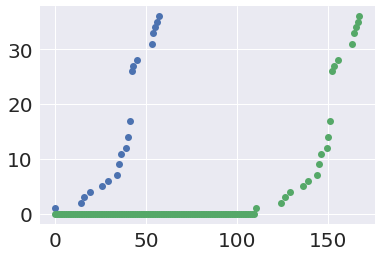

In [46]:
plt.plot(Rec_F04, Cum_F04, 'o')
plt.plot(Rec_F04_start, Cum_F04_start, 'o')

# Different Models

In [47]:
θ_start = np.load('theta_season_F04_tol100_4tol.npy')#ɛ>0
maxtol_start = len(θ_start)-1
dim_start = len(θ_start[0])

θ_old = np.load('theta_old_F04_prior.npy') #ɛ>0
maxtol_old = len(θ_old)-1
dim_old = len(θ_old[0])

θ_new = np.load('theta_new_F04_prior.npy')#ɛ>0
maxtol_new = len(θ_new)-1
dim_new = len(θ_new[0])

θ_nonnew = np.load('theta_F04_prior_noexternal.npy') #ɛ = 0
maxtol_nonnew = len(θ_nonnew) -1
dim_nonnew = len(θ_nonnew[0])

θ_outbreak = np.load('theta_outbreak_F04.npy') # ɛ>0
maxtol_outbreak = len(θ_outbreak) - 1
dim_outbreak = len(θ_outbreak[0])

θ_nonoutbreak = np.load('theta_outbreak_F04_noexternal.npy') # ɛ = 0
maxtol_nonoutbreak = len(θ_nonoutbreak)-1
dim_nonoutbreak = len(θ_nonoutbreak[0])

θ_nonold = np.load('theta_F04_noexternal_season.npy') #ɛ = 0
maxtol_nonold = len(θ_nonold)-1
dim_nonold = len(θ_nonold[0])

In [48]:
M_start = modesimulations(gillespieSEIR_season, θ_start, maxtol_start, dim_start, 1, 1000, 1000, 
                    Rec_F04_start, Cum_F04_start, Rec_F04, Cum_F04)
print(1)
M_old = modesimulations(gillespieSEIR_season_exposed, θ_old, maxtol_old, dim_old, 1, 1000, 1000, 
                    Rec_F04_start, Cum_F04_start, Rec_F04, Cum_F04)
print(2)
M_new = modesimulations(gillespieSEIR_season_exposed, θ_new, maxtol_new, dim_new, 1, 1000, 1000, 
                    Rec_F04_start, Cum_F04_start, Rec_F04, Cum_F04)
print(3)
M_nonnew = modesimulations(gillespieSEIR_season_exposed, θ_nonnew, maxtol_nonnew, dim_nonnew, 0, 1000, 1000, 
                    Rec_F04_start, Cum_F04_start, Rec_F04, Cum_F04)
print(4)
M_nonoutbreak = modesimulations(gillespieSEIR_season_exposed, θ_nonoutbreak, maxtol_nonoutbreak, dim_nonoutbreak, 0, 1000, 1000, 
                    Rec_F04_start, Cum_F04_start, Rec_F04, Cum_F04)
print(5)
M_outbreak = modesimulations(gillespieSEIR_season_exposed, θ_outbreak, maxtol_outbreak, dim_outbreak, 1, 1000, 1000, 
                    Rec_F04_start, Cum_F04_start, Rec_F04, Cum_F04)
print(6)
M_nonold = modesimulations(gillespieSEIR_season_exposed, θ_nonold, maxtol_nonold, dim_nonold, 0, 1000, 1000, 
                    Rec_F04_start, Cum_F04_start, Rec_F04, Cum_F04)

print(7)
matrices = [M_start[0], M_old[0], M_new[0], M_nonnew[0], M_outbreak[0], M_nonoutbreak[0], M_nonold[0]]
# mode = [modes(i) for i in matrices]


/home/emma/.local/lib/python3.5/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in double_scalars
/home/emma/.local/lib/python3.5/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


1


/home/emma/.local/lib/python3.5/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in double_scalars
/home/emma/.local/lib/python3.5/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in double_scalars


2
3


/home/emma/.local/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:412: RuntimeWarning: invalid value encountered in double_scalars
  return m3 / np.power(m2, 1.5)
/home/emma/.local/lib/python3.5/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


4
5
6
7


In [50]:
# # mode = [modes(i) for i in matrices]
mode_start = modes(matrices[0])
print(1)
mode_old = modes(matrices[1])
print(2)
mode_new = modes(matrices[2])
print(3)
mode_nonnew = modes(matrices[3])
print(4)
mode_outbreak = modes(matrices[4])
print(5)
mode_nonoutbreak = modes(matrices[5])

1
2
3
4
5


In [52]:
matrices = [M_start[0],M_nonnew[0],M_old[0],  M_new[0],M_nonoutbreak[0], M_outbreak[0]]
names = ['1', '2','3', '4', '5', '6']
mode = [mode_start, mode_nonnew,mode_old, mode_new,  mode_nonoutbreak, mode_outbreak]
palette = sns.color_palette("Paired", len(mode))
pal2 = sns.color_palette("Paired_d", len(mode))
colors = ['#98eff9', '#0485d1', '#b1d27b', '#048243', '#c875c4', '#fc5a50']
colors2 = ['purple', 'navy', '#980002', '#74a662', 'white', 'red']
palette[1]
max_ma = 1000

(0, 80)

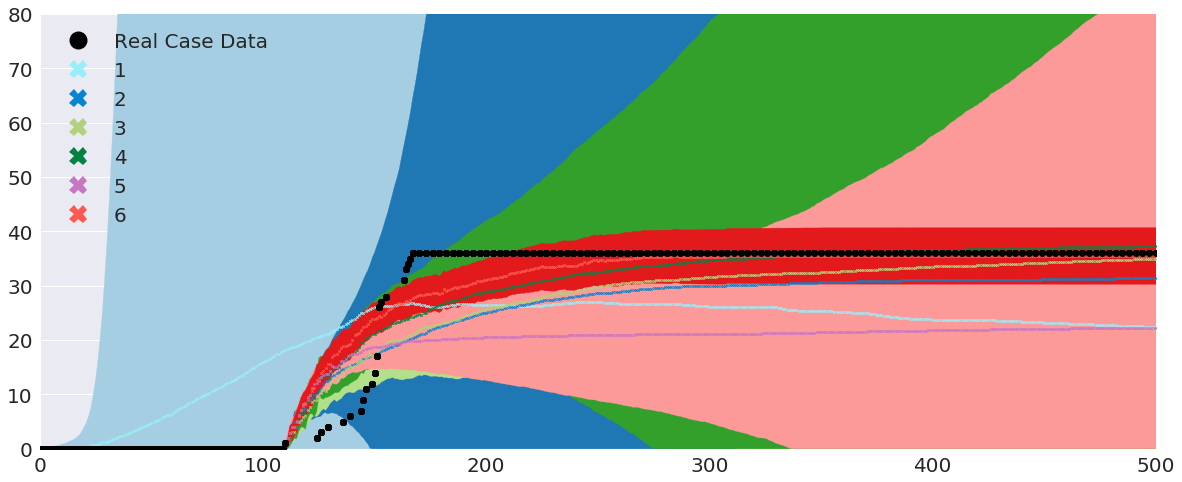

In [53]:
fig, ax = plt.subplots(figsize = (20,8))

for r in range(len(matrices)):
    if r == 0:
        true, = ax.plot(M_start[1], M_start[2], 'o', markersize = 3, color = 'black', label = 'Real Case Data')

        ax.plot(range(max_ma), mode[r], 'X', markersize = 3,linewidth = 4, color = colors[r], label = '{}'.format(names[r]))
        plt.fill_between(range(max_ma),  ( mode[r]+np.std(matrices[r], axis = 0)), np.maximum(( mode[r]-np.std(matrices[r], axis = 0)),0), 1, alpha=1, color = palette[r])
    else:
        ax.plot(np.arange(110, 1110,1), mode[r], 'X', markersize = 3,linewidth = 4,color = colors[r], label = '{}'.format(names[r]))
        true, = ax.plot(M_nonnew[1], M_nonnew[2], 'o', color = 'black')

        plt.fill_between(np.arange(110, 1110,1),  ( mode[r]+np.std(matrices[r], axis = 0)), np.maximum(( mode[r]-np.std(matrices[r], axis = 0)),0), 1, alpha=1, color = palette[r])
plt.xlim([0,500])
plt.legend(loc = 'upper left', fontsize = 20, markerscale=6.)
plt.ylim([0,80])

Text(0.5,1,'Started from outbreak.\n Prior taken from start of season fit')

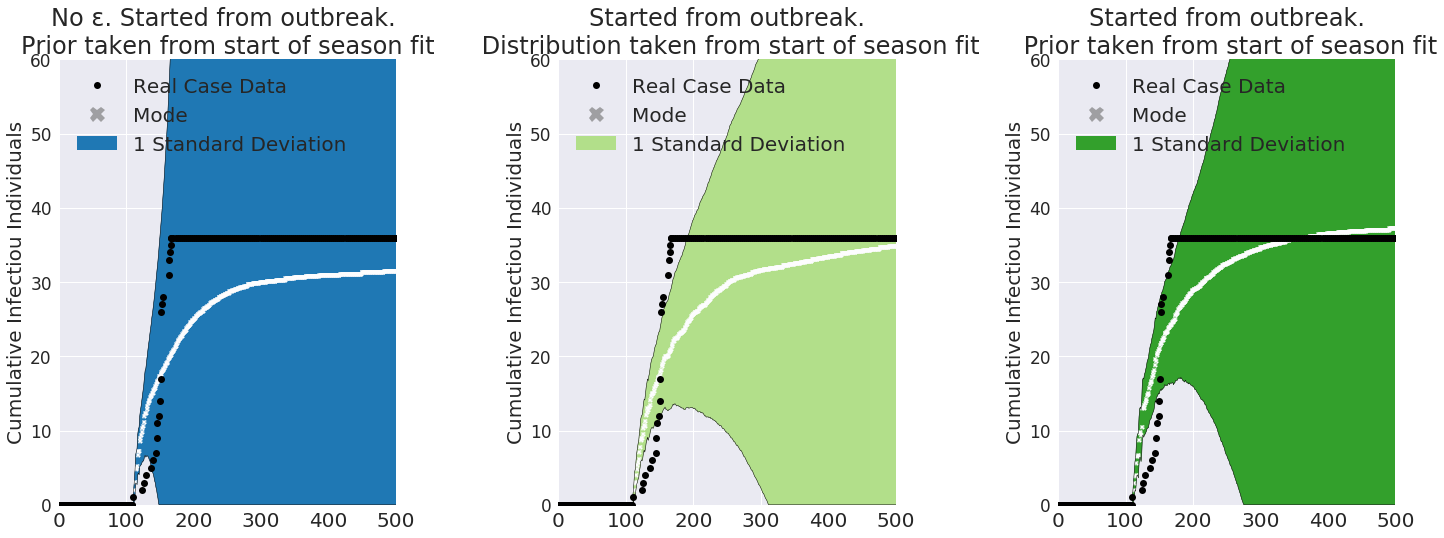

In [87]:
fig, ax = plt.subplots(figsize=(20,8))
plt.subplot(1,3,1)
plt.plot(np.arange(110, 1110,1), mode_nonnew, 'X', markersize = 5,linewidth = 6, color = '#fdfdfe', label = 'Mode')
plt.plot(np.arange(110, 1110,1), (mode_nonnew+np.std(matrices[1], axis = 0)), color ='k', lw=0.5)
plt.plot(np.arange(110, 1110,1), np.maximum((mode_nonnew-np.std(matrices[1], axis = 0)),0),color ='k', lw=0.5)
plt.fill_between(np.arange(110, 1110,1),  (mode_nonnew+np.std(matrices[1], axis = 0)), np.maximum((mode_nonnew-np.std(matrices[1], axis = 0)),0), 1, alpha=1, color = palette[1])
true, = plt.plot(M_old[1], M_old[2], 'o', color = 'black', label = 'Real Case Data')

plt.ylabel('Cumulative Infectiou Individuals', fontsize = 20)
# plt.xlabel('Time, days', fontsize = 20)
patch = mpatches.Patch(facecolor=palette[1], alpha=1, linewidth=0, label = '1 Standard Deviation')

blue_line = mlines.Line2D([], [], color='grey', alpha = 0.7, marker='X',
                          markersize=15, linestyle = '', linewidth = 2,  label='Mode')
plt.legend(handles=[true,blue_line, patch], fontsize = 20, loc = 'upper left')
plt.tight_layout()
plt.yticks(fontsize = 17)
plt.xlim([0,500])
plt.ylim([0,60])
plt.title('No ɛ. Started from outbreak. \nPrior taken from start of season fit')

plt.subplot(1,3,2)
plt.plot(np.arange(110, 1110,1), mode_old, 'X', markersize = 5,linewidth = 6, color = '#fdfdfe', label = 'Mode')
plt.plot(np.arange(110, 1110,1), (mode_old+np.std(matrices[2], axis = 0)), color ='k', lw=0.5)
plt.plot(np.arange(110, 1110,1), np.maximum((mode_old-np.std(matrices[2], axis = 0)),0),color ='k', lw=0.5)
plt.fill_between(np.arange(110, 1110,1),  (mode_old+np.std(matrices[2], axis = 0)), np.maximum((mode_old-np.std(matrices[2], axis = 0)),0), 1, alpha=1, color = palette[2])
true, = plt.plot(M_old[1], M_old[2], 'o', color = 'black', label = 'Real Case Data')

plt.ylabel('Cumulative Infectiou Individuals', fontsize = 20)
# plt.xlabel('Time, days', fontsize = 20)
patch = mpatches.Patch(facecolor=palette[2], alpha=1, linewidth=0, label = '1 Standard Deviation')

blue_line = mlines.Line2D([], [], color='grey', alpha = 0.7, marker='X',
                          markersize=15, linestyle = '', linewidth = 2,  label='Mode')
plt.legend(handles=[true,blue_line, patch], fontsize = 20, loc = 'upper left')
plt.tight_layout()
plt.yticks(fontsize = 17)
plt.xlim([0,500])
plt.ylim([0,60])
plt.title('Started from outbreak.\n Distribution taken from start of season fit')


plt.subplot(1,3,3)
plt.plot(np.arange(110, 1110,1), mode_new, 'X', markersize = 5,linewidth = 6, color = '#fdfdfe', label = 'Mode')
plt.plot(np.arange(110, 1110,1), (mode_new+np.std(matrices[3], axis = 0)), color ='k', lw=0.5)
plt.plot(np.arange(110, 1110,1), np.maximum((mode_new-np.std(matrices[3], axis = 0)),0),color ='k', lw=0.5)
plt.fill_between(np.arange(110, 1110,1),  (mode_new+np.std(matrices[3], axis = 0)), np.maximum((mode_new-np.std(matrices[3], axis = 0)),0), 1, alpha=1, color = palette[3])
true, = plt.plot(M_old[1], M_old[2], 'o', color = 'black', label = 'Real Case Data')

plt.ylabel('Cumulative Infectiou Individuals', fontsize = 20)
# plt.xlabel('Time, days', fontsize = 20)
patch = mpatches.Patch(facecolor=palette[3], alpha=1, linewidth=0, label = '1 Standard Deviation')

blue_line = mlines.Line2D([], [], color='grey', alpha = 0.7, marker='X',
                          markersize=15, linestyle = '', linewidth = 2,  label='Mode')
plt.legend(handles=[true,blue_line, patch], fontsize = 20, loc = 'upper left')
plt.tight_layout()
plt.yticks(fontsize = 17)
plt.xlim([0,500])
plt.ylim([0,60])
plt.title('Started from outbreak.\n Prior taken from start of season fit')


# Compare Distributions

In [64]:

def dataframedist(theta, maxtol, name):
    param = ['β', 'ɛ', 'σ', 'μ1', 'μ2', 'Exposed']
    df = pd.DataFrame(columns = ['parameter distribution', 'parameter'])
    for i in range(len(param)):
        df3 = pd.DataFrame()
        if 5>i>1:
            df3['parameter distribution'] =[1/a for a in  theta[maxtol][:,i]]
            df3['parameter'] = param[i]
        if i ==5:
            if len(theta[0][0])<6:
                df3['parameter distribution'] =np.zeros(100)
                df3['parameter'] = param[i]
            else:
                df3['parameter distribution'] =[a for a in  theta[maxtol][:,i]]
                df3['parameter'] = param[i]
        else:
            df3['parameter distribution'] =[a for a in  theta[maxtol][:,i]]
            df3['parameter'] = param[i]
            
        
        df = df.append(df3, ignore_index = True)
    df['Model'] = name
    return df

In [65]:
d1 = dataframedist(θ_start, maxtol_start, 'Start of Season')
d2 = dataframedist(θ_old, maxtol_old, 'Prior = Posterior')
d3 = dataframedist(θ_new, maxtol_new, 'Prior = sos')
d4 = dataframedist(θ_nonnew, maxtol_nonnew, 'No ɛ, prior = Sos')
d5 = dataframedist(θ_outbreak, maxtol_outbreak, 'Prior = uniform')
d6 = dataframedist(θ_nonoutbreak, maxtol_nonoutbreak, 'No ɛ, prior = uniform')
Names = ['Start of Season','Prior = Posterior','Prior = sos','No ɛ, prior = Sos','Prior = uniform','No ɛ, prior = uniform']

In [66]:
df = d1.append([d4, d2, d3, d6, d5])
    
    # df = df.append(df8, ignore_index = True)

/home/emma/.local/lib/python3.5/site-packages/matplotlib/legend.py:593: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f7d1d30a438> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


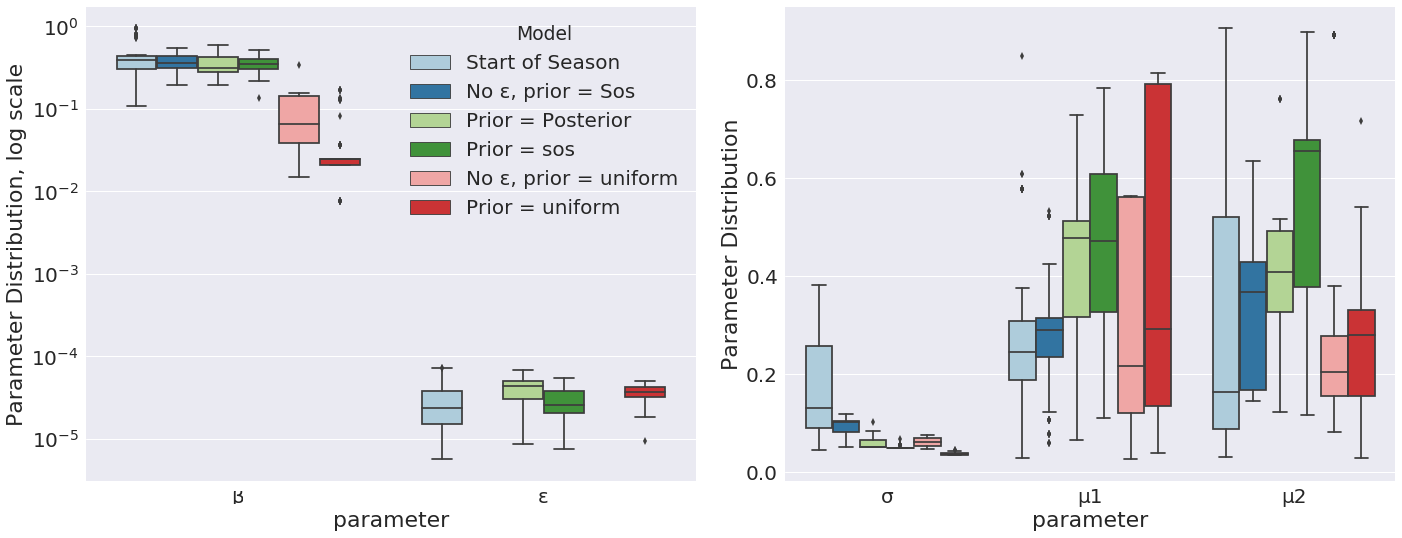

In [69]:
# sns.palplot(sns.color_palette("GnBu_d"))
plt.figure(figsize = (20,8))
sns.set(font_scale=2)  # crazy big
cmap = sns.color_palette("GnBu_d")
plt.subplot(1,2,1)
sns.boxplot(x = 'parameter', y = 'parameter distribution', data = df.loc[df['parameter'].isin(['β','ɛ'])], hue = 'Model' , palette = 'Paired')
plt.ylabel('Parameter Distribution, log scale')
plt.yscale('log')

plt.subplot(1,2,2)

# plt.subplot(1,1, 1)
# sns.boxplot(x = 'parameter', y = 'parameter distribution', data = df.loc[df['parameter'].isin(['β','ɛ'])], hue = 'case' , palette = 'Paired')
sns.boxplot(x = 'parameter', y = 'parameter distribution', data = df.loc[df['parameter'].isin(['σ', 'μ1', 'μ2'])], hue = 'Model' , palette = 'Paired')

# plt.yscale('log')
plt.ylabel('Parameter Distribution')
plt.legend(labels=['_nolegend_'])
plt.tight_layout()
# plt.savefig('paramdist.pdf')

# plt.subplot(2,1,2)
# plt.legend(fontsize = 20)

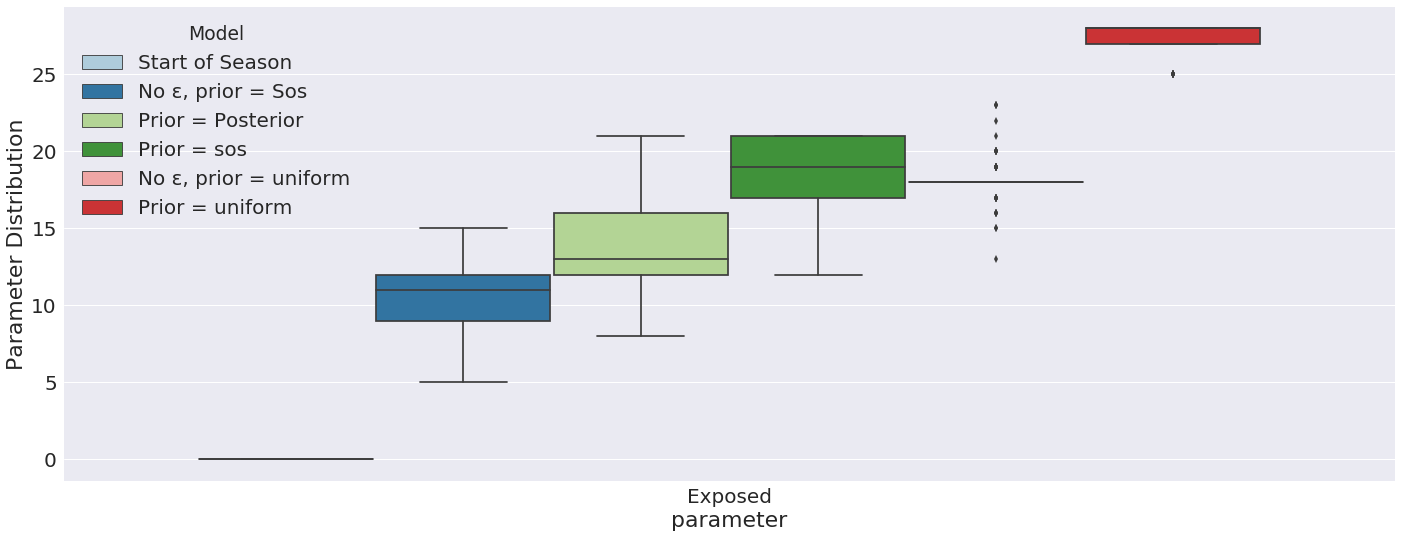

In [70]:
# plt.subplot(1,1,1)
plt.figure(figsize = (20, 8))
sns.boxplot(x = 'parameter', y = 'parameter distribution', data = df.loc[df['parameter'].isin(['Exposed'])], hue = 'Model' , palette = 'Paired')

plt.ylabel('Parameter Distribution')
plt.tight_layout()

# Compare Summary Statistics

In [71]:
[M_start[0],M_nonnew[0],M_old[0],  M_new[0],M_nonoutbreak[0], M_outbreak[0]]
def summarystats(M, name):
    param = ['External Infections', 'Human 2 Human', 'Total Infections', 'Fatality']
    df = pd.DataFrame(columns = ['Percentage %', 'Summary Statistic'])
    for i in range(3, 3+len(param)):
        df3 = pd.DataFrame()
        if i ==3:
#             print(i)
            df3['Percentage %'] =[100*(M[i][a]/M[5][a]) for a in range(len(M[i]))]
            df3['Summary Statistic'] = param[i-3]
            
        elif i ==4:
            df3['Percentage %'] =[100*(M[i][a]/M[5][a]) for a in range(len(M[i]))]
            df3['Summary Statistic'] = param[i-3]
            
        elif i ==6:
            df3['Percentage %'] =[100*(M[i][a]/M[5][a]) for a in range(len(M[i]))]
            df3['Summary Statistic'] = param[i-3]
        else:
#             print(i)
            df3['Percentage %'] =M[i]
            df3['Summary Statistic'] = param[i-3]
        df = df.append(df3, ignore_index = True)
    df['Model'] = name
    return df

In [72]:
D1 = summarystats(M_start, Names[0])
D2 = summarystats(M_old, Names[1])
D3 = summarystats(M_new, Names[2])
D4 = summarystats(M_nonnew, Names[3])
D5 = summarystats(M_outbreak, Names[4])
D6 = summarystats(M_nonoutbreak, Names[5])

In [73]:
Df = D1.append([D4, D2, D3, D6, D5])

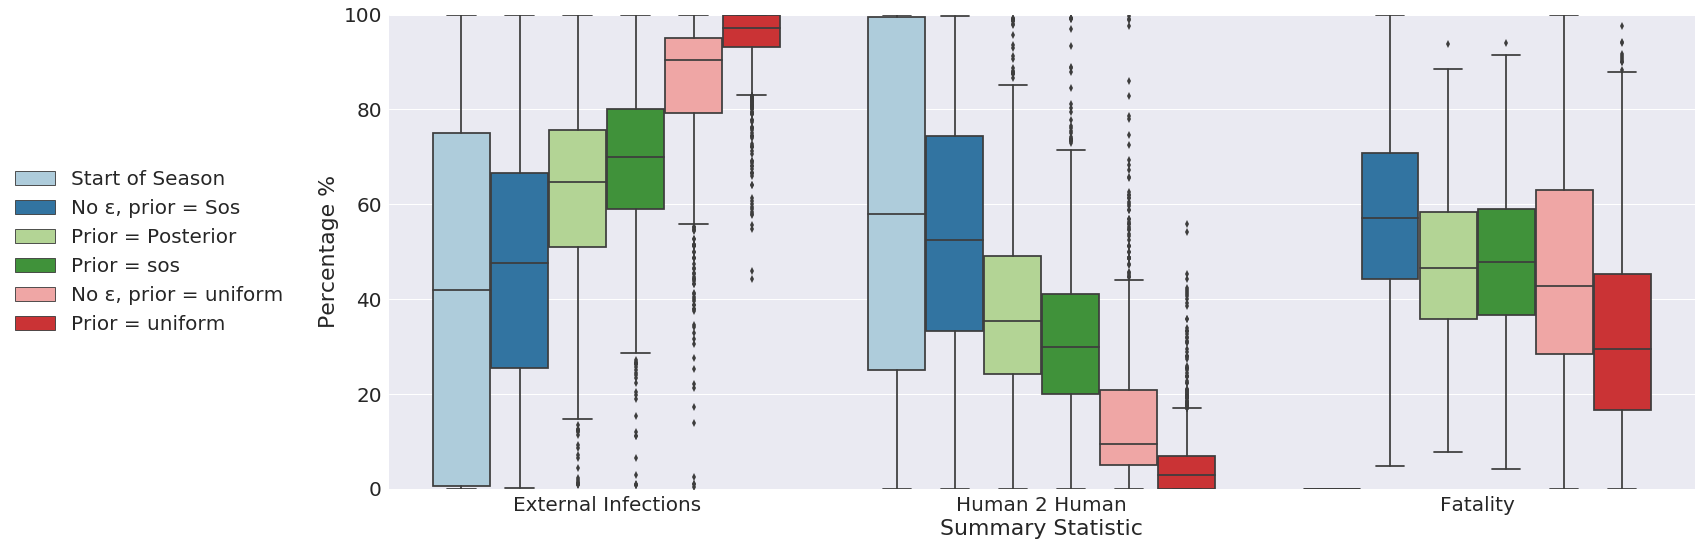

In [74]:
plt.figure(figsize = (20, 8))
sns.boxplot(x = 'Summary Statistic', y = 'Percentage %', data = Df.loc[Df['Summary Statistic'].isin(['External Infections', 'Human 2 Human', 'Fatality'])], hue = 'Model' , palette = 'Paired')
# plt.yscale('log')
plt.ylabel('Percentage %')
plt.tight_layout()
plt.ylim([0,100])
plt.legend(loc = 'center left', bbox_to_anchor=[-0.3, 0.5], fontsize = 20)

In [82]:
print('mean, mode fatality', np.mean(D3[D3['Summary Statistic']=='Fatality']['Percentage %']), stats.mode(D3[D3['Summary Statistic']=='Fatality']['Percentage %'])[0][0])
print('mean, mode h2h', np.mean(D3[D3['Summary Statistic']=='Human 2 Human']['Percentage %']), stats.mode(D3[D3['Summary Statistic']=='Human 2 Human']['Percentage %'])[0][0])
print('mean, mode external', np.mean(D3[D3['Summary Statistic']=='External Infections']['Percentage %']), stats.mode(D3[D3['Summary Statistic']=='External Infections']['Percentage %'])[0][0])
print('mean, mode total infections', np.mean(D3[D3['Summary Statistic']=='Total Infections']['Percentage %']), stats.mode(D3[D3['Summary Statistic']=='Total Infections']['Percentage %'])[0][0])

mean, mode fatality 47.82753624361251 50.0
mean, mode h2h 31.98355690674846 33.33333333333333
mean, mode external 68.01644309325152 66.66666666666666
mean, mode total infections 53.654 33.0


# Reproduction Numbers

Luby predicted R0 to 0.48, estimated by dividing number of persons infected by a primary case-patient by total number of primary cases 

--- Recurrent Zoonotic Transmission  of Nipah Virus into Humans,  Bangladesh, 2001–2007 DOI:	10.3201/eid1508.081237

In [99]:
def h2hr0(beta,mu, mu1,mu2,sigma):
    return (beta*sigma)/((sigma+mu)*(mu1+mu2+mu)) 

a_β, loc_β, scale_β = stats.gamma.fit(θ_new[maxtol_new][:,0])
a_ϵ, loc_ϵ, scale_ϵ = stats.gamma.fit(θ_new[maxtol_new][:,1])
a_σ, loc_σ, scale_σ = stats.gamma.fit([1/a for a in θ_new[maxtol_new][:,2]])
a_μ1, loc_μ1, scale_μ1 = stats.gamma.fit([1/a for a in θ_new[maxtol_new][:,3]])
a_μ2, loc_μ2, scale_μ2 = stats.gamma.fit([1/a for a in θ_new[maxtol_new][:,4]])

β = stats.gamma.rvs( a_β, loc_β, scale_β)
μ1 = 1/stats.gamma.rvs( a_μ1, loc_μ1, scale_μ1)
μ2 = 1/stats.gamma.rvs( a_μ2, loc_μ2, scale_μ2)
σ = 1/stats.gamma.rvs( a_σ, loc_σ, scale_σ)
ϵ = stats.gamma.rvs( a_ϵ, loc_ϵ, scale_ϵ)

random_E = np.random.randint(0,dim_new-1)
exposed = θ_new[maxtol_new][:,5][random_E]

In [105]:
μ = 1/(67*365)
h2hr0(β, μ, μ1, μ2, σ) # H2H R0

0.41269473017807834

In [102]:
G=gillespieSEIR_season_exposed(exposed, β, μ1,μ2,σ,ϵ)
SEIRt_s = G[0]
SEIRs_s = G[1][:,0]
SEIRe_s = G[1][:,1]
SEIRi_s = G[1][:,2]
SEIRr_s = G[1][:,3]

/home/emma/.local/lib/python3.5/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in double_scalars


In [103]:
manhes = []
manhts = []
manhhs = []
manhis = []
manhss = []
manhrs = []
cum = []
for ind, x in enumerate(SEIRt_s):
    if ind<len(SEIRt_s)-1:
        manhes.append((SEIRe_s[ind], SEIRe_s[ind]))
        cum.append((G[3][ind], G[3][ind]))
        manhis.append((SEIRi_s[ind], SEIRi_s[ind]))
        manhss.append((SEIRs_s[ind], SEIRs_s[ind]))
        manhrs.append((SEIRr_s[ind], SEIRr_s[ind]))
        manhts.append((SEIRt_s[ind], SEIRt_s[ind+1]))
manhes = np.array(manhes).flatten()
manhts = np.array(manhts).flatten()
manhss = np.array(manhss).flatten()
manhrs = np.array(manhrs).flatten()
cum = np.array(cum).flatten()
manhis = np.array(manhis).flatten()

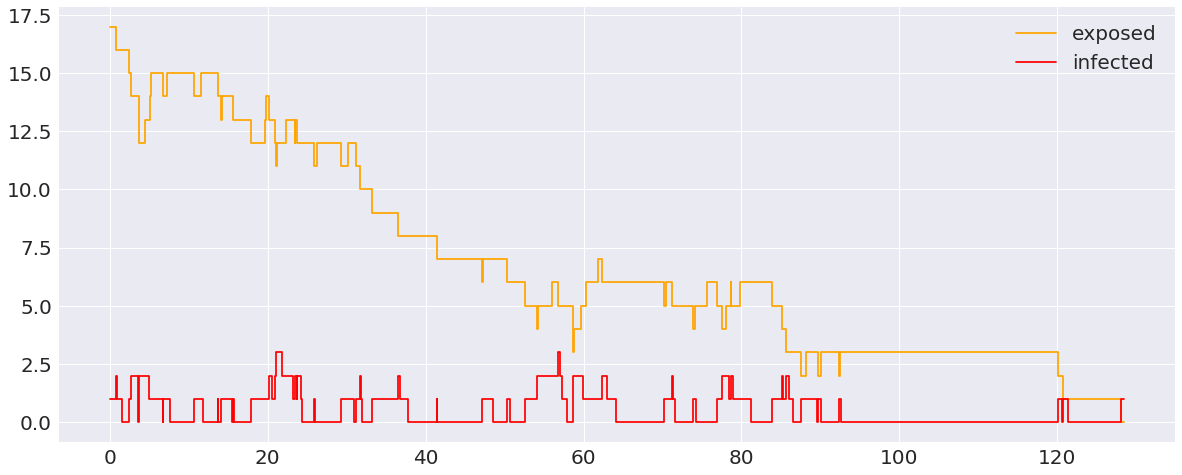

In [104]:
plt.figure(figsize = (20,8))
N = 1501
plt.plot(manhts, manhes,c='orange', label = 'exposed')

plt.plot(manhts,manhis,c= 'r', label = 'infected')
plt.legend(fontsize = 20)
# plt.xlim([0,300])